# A projection into a finite element space
The following requires assembly a finite element
matrix (the mass matrix) and a right hand side.
We use linear Lagrange shape functions.

So we are looking for the $L^2$ projection
\begin{align*}
   u_h(x) = \sum_k u_k\varphi_k(x)
\end{align*}
which is the solution of
\begin{align*}
  \int_\Omega u_h\varphi_i &= \int_\Omega u\varphi_i, && \text{for all $i$}
\end{align*}
We assume that on an element $E$ we have
\begin{align*}
  \varphi_{g_E(k)}(x) = \hat\varphi_k(F_E^{-1}(x))
\end{align*}
for $k=0,1,2$ and where $g_E$ denotes the local to global dof mapper
and $F_E$ is the reference mapping.

So we need to compute
\begin{align*}
  M^E_{kl} := \int_{\hat{E}} |DF|\hat\varphi_k\hat\varphi_l~, &&
  b^E_l := \int_E u\varphi_l~,
\end{align*}
and distribute these into a global matrix.

In [22]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from dune.geometry import quadratureRules, quadratureRule
from dune.grid import cartesianDomain, gridFunction

# We will use a triangular grid for this exercise
from dune.alugrid import aluConformGrid
from matplotlib import pyplot as plt

## The shape functions
We use a simple class here to collect all required
information about the finite element space, i.e.,
how to evaluate the shape functions on the reference
element (together with their derivatives). We also
setup a mapper to attach the degrees of freedom to
the entities of the grid.

### Task
Write a class LinearLagrangeSpace that provides 3 methods:
```
class LinearLagrangeSpace:
   def __init__(self,view):
       self.view = view
       # TODO: Create a mapper for vertex indices
       self.mapper = see yesterdays exercises
       self.localDofs = 3
       self.points = numpy.array( [ [0,0],[1,0],[0,1] ] )
   def evaluateLocal(self, x):
       # TODO: Return a numpy array with the evaluations
       #       of the 3 basis functions in local point x
       # return numpy.array( [] )
       pass
   def gradientLocal(self, x):
       # TODO: Return a numpy array with the evaluations
       #       of the gradients of the 3 basis functions in local point x
       # return numpy.array( dbary )
       pass
```


In [23]:
##### TASK
class LinearLagrangeSpace:
    def __init__(self, view):
        self.view = view
        self.mapper = view.mapper([0,0,1])
        self.localDofs = 3
        self.points = np.array([[0,0],[1,0],[0,1]])
        self.basis = lambda x: np.array([1-x[0]-x[1], x[0], x[1]])
        self.gradBasis = lambda x: np.array([[-1,-1],[1,0],[0,1]])
        
    def evaluateLocal(self, x):
        return self.basis(x)
    
    def gradientLocal(self,x):
        return self.gradBasis(x)
    
class QuadraticLagrangeSpace:
    def __init__(self, view):
        self.view =view
        self.mapper = view.mapper([0,0,1])
        self.localDofs = 6
        self.points = np.array([[0,0],[1,0],[0,1],[0.5,0],[0.5,0.5],[0,0.5]])
        self.basis = lambda x: np.array([1-3*x[0]-3*x[1]+2*x[0]*x[0]+4*x[0]*x[1]+2*x[1]*x[1], 4*x[0]-4*x[0]*x[0]-4*x[0]*x[1], 2*x[0]*x[0], 4*x[0]*x[1], -4*x[1]*x[1], 2*x[1]*x[1]])
        self.gradBasis = lambda x: np.array([[-3-2*x[1],-3-2*x[0]],[4-8*x[0]-4*x[1],-4*x[0]],[4*x[0],0],[4*x[1],4*x[0]],[0,-8*x[1]],[0,4*x[1]]])
        
    def evaluateLocal(self, x):
        return self.basis(x)
    

## The right hand side and matrix assembly
We need to iterate over the grid, construct the
local right hand side and the local system matrix.
After finishing the quadrature loop we store the
resulting local matrix in a structure provided by
the Python package scipy. There are many different
storage structures available - we use the so called
'coordinate' (COO) matrix format which requires us
construct three vectors, one to store the column
indices, one for the row indices, and one for the
values. The convention is that entries appearing
multiple times are summed up - exactly as we need it.
So after computing the local matrix and right hand side vector
$M^E$ we store the values $M^E_{kl}$ into the
values vector $v_{{\rm start}+3l+k} = M^E_{kl}$
and the associated global indices
$c_{{\rm start}+3l+k} = g_E(k)$ and
$r_{{\rm start}+3l+k} = g_E(l)$.

### Task
Implement a function that assembles the system matrix and the forcing term.
For this we will use the LinearLagrangeSpace. Use the attribute mapper from the LinearLagrangeSpace for
index mapping. Remember that the gradients of the basis functions obtained
from the LinearLagrangeSpace need to be converted to physical space using the
jacobianInverseTransposed of the geometry.

```
def assemble(space,force):
   # storage for right hand side
   rhs = numpy.zeros(len(space.mapper))

   # storage for local matrix
   localEntries = space.localDofs
   localMatrix = numpy.zeros([localEntries,localEntries])

   # data structure for global matrix using coordinate (COO) format
   globalEntries = localEntries**2 * space.view.size(0)
   value = numpy.zeros(globalEntries)
   rowIndex, colIndex = numpy.zeros(globalEntries,int), numpy.zeros(globalEntries,int)

   # TODO: implement assembly of matrix and forcing term
   ...

   # convert data structure to compressed row storage (csr)
   matrix = scipy.sparse.coo_matrix((value, (rowIndex, colIndex)),
                        shape=(len(space.mapper),len(space.mapper))).tocsr()
   return rhs,matrix


```

In [24]:
##### TASK
def assemble(space, force):
    rhs = np.zeros(space.mapper.size)
    global_entries = space.mapper.size * space.view.size(0)*2
    global_values = np.zeros(global_entries)
    rowIndex, colIndex = np.zeros(global_entries, dtype=int), np.zeros(global_entries, dtype=int)
    for i, element in enumerate(space.view.entities(codim=0)):
        local_indices = space.mapper.subIndices(element, 2)
        local_matrix = np.zeros((space.localDofs, space.localDofs))
        integral_rhs = np.zeros(space.localDofs)
        for p in quadratureRule(element.type, 4):
            w = p.weight * element.geometry.integrationElement(p.position)
            integral_rhs += w * force(element, p.position) * space.evaluateLocal(p.position)
            local_matrix += w * space.evaluateLocal(p.position)[:, None] * space.evaluateLocal(p.position)[None, :] 
        local_indices = np.array(local_indices)
        assert local_matrix.shape == (space.localDofs, space.localDofs)
        
        for index_k ,k in enumerate(local_indices):
            for index_j, j in enumerate(local_indices):
                rowIndex[k * space.mapper.size + j] = k
                colIndex[k * space.mapper.size + j] = j
                global_values[k*space.mapper.size + j] += local_matrix[index_k, index_j]
            rhs[k] += integral_rhs[index_k]
    matrix = scipy.sparse.coo_matrix((global_values, (rowIndex, colIndex)),
                        shape=(len(space.mapper),len(space.mapper))).tocsr()
    return rhs,matrix
        
            

## The main part of the code
Construct the grid and a grid function for the
right hand side, compute the projection and plot
on a sequence of global grid refinements:

First construct the grid

In [25]:
domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view   = aluConformGrid(domain)

then the grid function to project

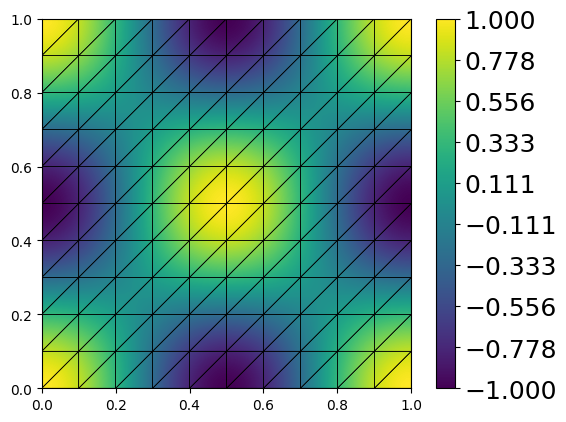

In [26]:
@gridFunction(view)
def u(p):
    x,y = p
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)
u.plot(level=3)

and then do the projection on a series of globally refined grids

number of elements: 200 number of dofs: 121


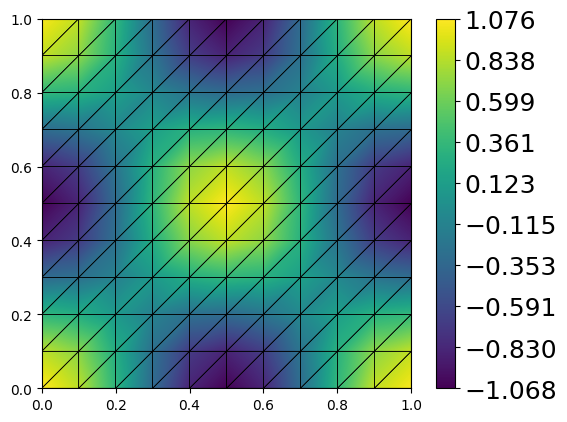

L2 error: 0.07629950312468407
number of elements: 800 number of dofs: 441


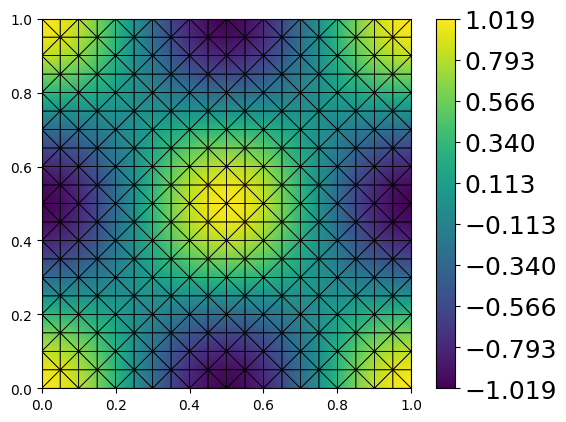

L2 error: 0.01749934704305245
number of elements: 3200 number of dofs: 1681


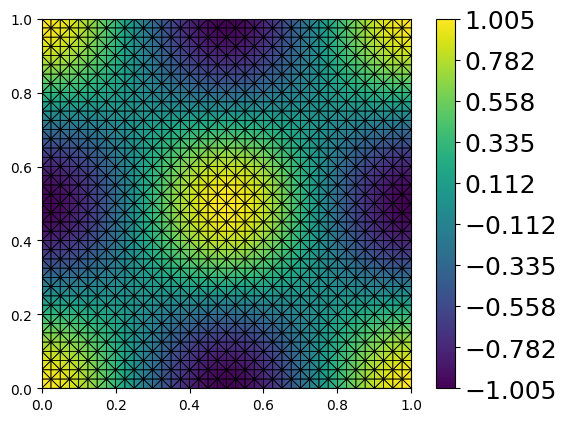

L2 error: 0.004360423772592964
number of elements: 12800 number of dofs: 6561


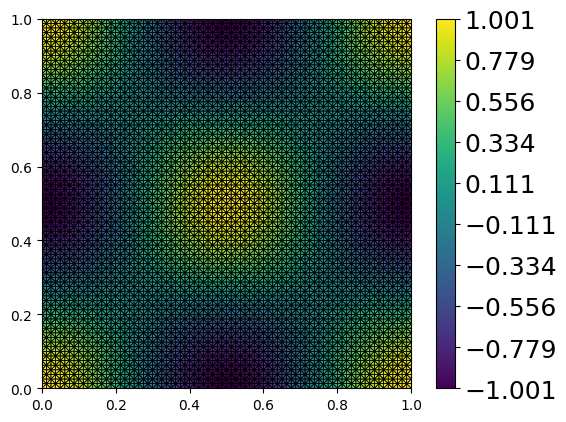

L2 error: 0.0010913527847233808


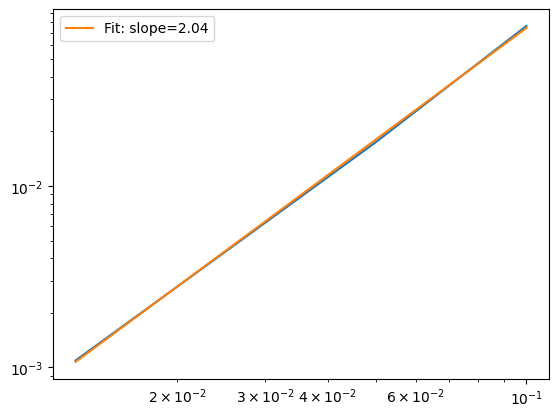

In [29]:
@gridFunction(view)
def u(p):
    x,y = p
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

domain = cartesianDomain([0, 0], [1, 1], [10, 10])
view   = aluConformGrid(domain)
error_list = []
number_refinement = 4
for ref in range(number_refinement):
    space  = LinearLagrangeSpace(view)
    print("number of elements:",view.size(0),"number of dofs:",len(space.mapper))
    rhs, matrix = assemble(space, u)
    dofs = scipy.sparse.linalg.spsolve(matrix,rhs)
    # print(matrix.toarray())
    # plt.imshow(matrix.toarray())
    @gridFunction(view)
    def uh(e,x):
        indices = space.mapper(e)
        phiVals = space.evaluateLocal(x)
        localDofs = dofs[indices]
        return np.dot(localDofs, phiVals)
    uh.plot(level=1)
    error = [np.power(u(element, element.geometry.center) - uh(element, element.geometry.center), 2) * element.geometry.volume for element in view.elements]
    print("L2 error:",np.sqrt(np.sum(error)))
    error_list.append(np.sqrt(np.sum(error)))
    view.hierarchicalGrid.globalRefine(2)
h_list = [1/2**i * 1/10 for i in range(number_refinement)]
plt.loglog(h_list,error_list)
coefficients = np.polyfit(np.log(h_list), np.log(error_list), 1)
plt.plot(h_list, np.exp(np.polyval(coefficients, np.log(h_list))), label=f'Fit: slope={coefficients[0]:.2f}')
plt.legend()
plt.show()


# Some tasks:

1.  Compute some error of the projection, i.e., in maximum
difference between uh and u at the center of each element,
or some $L^2$ type error over the domain, e.g.,
\begin{align*}
  \sqrt{\int_\Omega |u-u_h|^2}
\end{align*}
What are the EOCs?

__Experimental order of convergence__: (EOC)

This is a simple proceedure to test if a numerical scheme works:

Assume for example that one can prove that the error $e_h$ on a
grid with grid spacing $h$ satisfies
\begin{align*}
  e_h \approx Ch^p
\end{align*}
then
\begin{align*}
  \log \frac{e_h}{e_H} \approx p\log \frac{h}{H}
\end{align*}
which can be used to get a good idea about the convergence rate $p$
using the errors computed on two different levels of a hierarchical grid.

2. Implement an interpolation (e.g. as a method on the
`LinearLagrangeSpace` class) and compare the errors of the
interpolation with the errors/EOCs you computed for the projection.

3. Add a class with quadratic finite elements and look at the
errors/EOCs.

4. Have a look at the errors/EOCs in the derivatives:
\begin{align*}
  \sqrt{\int_\Omega |\nabla u-\nabla u_h|^2}
\end{align*}
Recall how the local basis functions are defined and use
the chain rule, the required method on the element's geometry
is `jacobianInverseTransposed(x)`...

5. Add a stiffness matrix and solve the Neuman problem:
\begin{align*}
  -\Delta u + u &= f, && \text{in } \Omega, \\
     \nabla u\cdot n &= 0, && \text{on } \partial\Omega,
\end{align*}
where $f$ is for example given by
```
@gridFunction(view)
def forcing(p):
    return u(p)*(2*(2*numpy.pi)**2+1)
```

Solution: this is implemented in `laplaceNeumann.py`

6. change the PDE, i.e., include varying coefficients...